In [1]:
import time
import copy
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision

from torch.autograd import Variable
from torchvision import datasets, models
from torchvision import transforms as T

plt.ion()

In [2]:
data_dir = '/datasets/hymenoptera_data'
BATCH_SIZE = 4
EPOCHS = 24

In [3]:
data_transforms = {
    'train': T.Compose([
        T.RandomSizedCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        T.Scale(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()

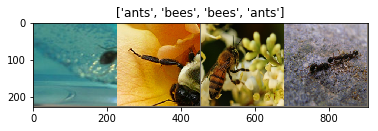

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dset_loaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dset_classes[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=EPOCHS):
    since = time.time()
    best_model = model
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch: {:2d}/{:2d}'.format(epoch+1, num_epochs))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)
            else:
                model.train(False)
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dset_loaders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                    
                optimizer.zero_grad()
                
                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds.data == labels.data)
            
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
        
        print()
                
            
    time_elapsed = time.time() - since
    print('Training Complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    return best_model

In [6]:
def exp_lr_scheduler(optimizer, epoch, init_lr=1e-3, lr_decay_epochs=7):
    lr = init_lr*(0.1**(epoch//lr_decay_epochs))
    
    if epoch % lr_decay_epochs == 0:
        print('LR is set to {}'.format(lr))
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
    return optimizer

In [7]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, (inputs, labels) in enumerate(dset_loaders['val']):
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.data.cpu().numpy().squeeze()
        
        for j in range(inputs.size(0)):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[preds[j]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft.cuda()
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=EPOCHS)

Epoch:  1/24
----------
LR is set to 0.001
train Loss: 0.1703 Acc: 0.6516
val Loss: 0.0470 Acc: 0.9346

Epoch:  2/24
----------
train Loss: 0.1237 Acc: 0.7992
val Loss: 0.0479 Acc: 0.9216

Epoch:  3/24
----------
train Loss: 0.1559 Acc: 0.7910
val Loss: 0.0970 Acc: 0.8693

Epoch:  4/24
----------
train Loss: 0.1034 Acc: 0.8279
val Loss: 0.1118 Acc: 0.8562

Epoch:  5/24
----------
train Loss: 0.1095 Acc: 0.7992
val Loss: 0.0783 Acc: 0.8758

Epoch:  6/24
----------
train Loss: 0.1311 Acc: 0.7869
val Loss: 0.1349 Acc: 0.8039

Epoch:  7/24
----------
train Loss: 0.1515 Acc: 0.7541
val Loss: 0.0714 Acc: 0.8627

Epoch:  8/24
----------
LR is set to 0.0001
train Loss: 0.0902 Acc: 0.8402
val Loss: 0.0614 Acc: 0.8758

Epoch:  9/24
----------
train Loss: 0.0787 Acc: 0.8607
val Loss: 0.0566 Acc: 0.8758

Epoch: 10/24
----------
train Loss: 0.0790 Acc: 0.8607
val Loss: 0.0615 Acc: 0.8824

Epoch: 11/24
----------
train Loss: 0.0751 Acc: 0.8648
val Loss: 0.0604 Acc: 0.9020

Epoch: 12/24
----------
tr

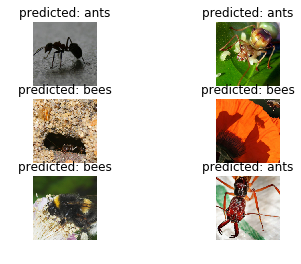

In [10]:
visualize_model(model_ft)